# Pattern formation

initial-boundary value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$
\begin{align*}
\frac{\partial a}{\partial t} &= D_a\nabla^2a + R_a(a,b) \\
\frac{\partial b}{\partial t} &= D_b\nabla^2b + R_b(a,b)
\end{align*}
$$

In [ ]:
from ufl.core.expr import Expr
from ufl import Form, dx, inner, grad, TestFunction

from lucifex.mesh import rectangle_mesh
from lucifex.fdm import (
    DT, BE, FE, finite_difference_order,
    FiniteDifference, FunctionSeries, ConstantSeries,
)
from lucifex.fem import LUCiFExConstant as Constant
from lucifex.solver import ibvp_solver
from lucifex.sim import integrate, Simulation
from lucifex.viz import plot_colormap
from lucifex.utils import SpatialPerturbation, cubic_noise


def reaction_diffusion(
    u: FunctionSeries,
    dt: Constant,
    d: Constant,
    r: Expr,
    D_diff: FiniteDifference,
    D_reac: FiniteDifference,
) -> list[Form]:
    v = TestFunction(u.function_space)
    Ft = v * DT(u, dt) * dx
    Fd = inner(grad(v), d * grad(D_diff(u))) * dx
    Fr = -v * D_reac(r) * dx
    return [Ft, Fd, Fr]


Fitzhugh-Nagumo equations

$$
\begin{align*}
R_a(a,b;\alpha) &= a - a^3 -b - \alpha \\
R_b(a,b;\beta) &= \beta(a - b)
\end{align*}
$$

In [ ]:
def fitzhugh_nagumo_simulation(
    Lx: float,
    Ly: float,
    Nx: int,
    Ny: int,
    dt: float,
    Da: float,
    Db: float,
    alpha: float,
    beta: float,
    D_diff: FiniteDifference,
    D_reac: FiniteDifference,
    noise_freq: tuple[int, int],
    store: int | float,
):
    assert D_reac.is_explicit
    order = finite_difference_order(D_diff.order, D_reac.order)
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny)
    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    Da = Constant(mesh, Da, name='Da') 
    Db = Constant(mesh, Db, name='Db')
    alpha = Constant(mesh, alpha, name='alpha') 
    beta = Constant(mesh, beta, name='beta')  

    a_ics = SpatialPerturbation(
        0.0,
        cubic_noise(['neumann', 'neumann'], [Lx, Ly], noise_freq, (123, 456), (0, 1)),
        [Lx, Ly],
        5e-2, 
    )
    a = FunctionSeries((mesh, 'P', 1), 'a', order, store, a_ics)
    b_ics = SpatialPerturbation(
        0.0,
        cubic_noise(['neumann', 'neumann'], [Lx, Ly], noise_freq, (789, 987), (0, 1)),
        [Lx, Ly],
        5e-2, 
    )
    b = FunctionSeries((mesh, 'P', 1), 'b', order, store, b_ics)

    Ra = a - a**3 - b - alpha
    Rb = beta * (a - b) 

    a_solver = ibvp_solver(reaction_diffusion)(a, dt, Da, Ra, D_diff, D_reac)
    b_solver = ibvp_solver(reaction_diffusion)(b, dt, Db, Rb, D_diff, D_reac) 
    solvers = [a_solver, b_solver]

    return Simulation(solvers, t, dt)


Lx = 1.0
Nx = 64
Ly = 1.0
Ny = 64
Da = 1.0
Db = 100.0
alpha = -0.005
beta = 10.0
delta_x = Lx / Nx
delta_y = Ly / Ny
h = min(delta_x, delta_y)
dt = 0.001
noise_freq = (16, 16)
store = 0.1
simulation = fitzhugh_nagumo_simulation(
    Lx, 
    Ly,
    Nx,  
    Ny, 
    dt, 
    Da,
    Db,
    alpha,
    beta,
    BE,
    FE,
    noise_freq,
    store
)

In [ ]:
t_stop = 10.0
integrate(simulation, t_stop=t_stop)

a = simulation['a']
b = simulation['b']

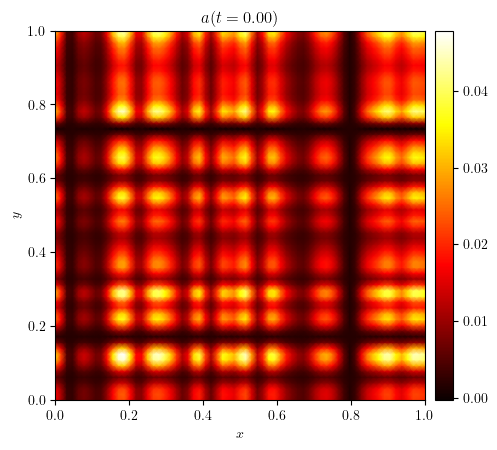

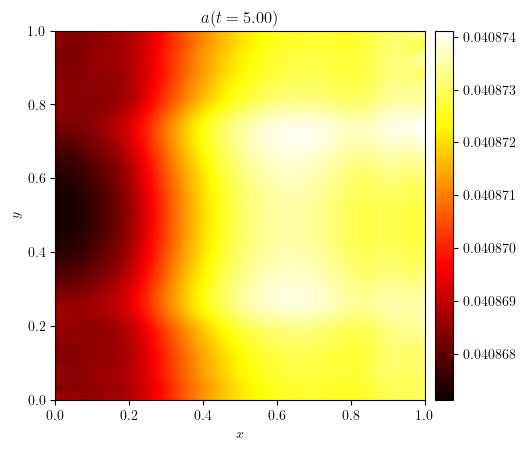

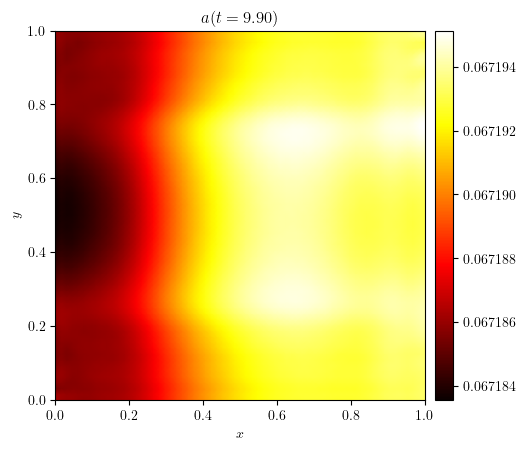

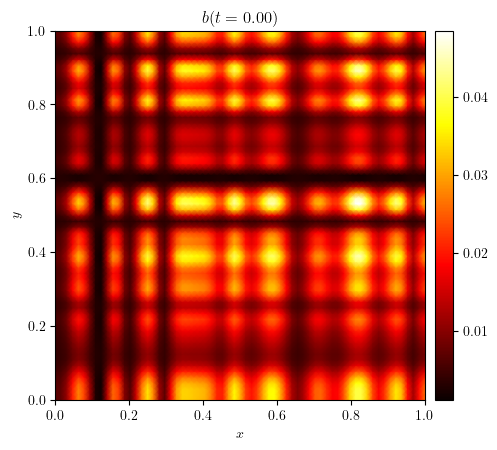

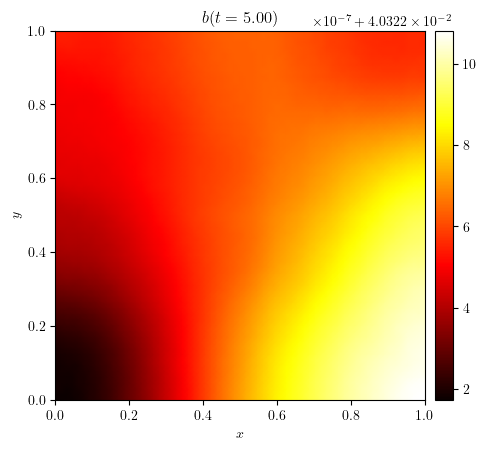

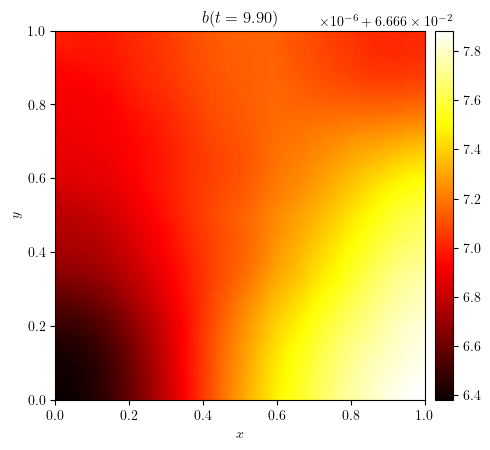

In [8]:
for q in (a, b):
    for n in (0, int(len(q.series) / 2), -1):
        plot_colormap(q.series[n], title=f'${q.name}(t={q.time_series[n]:.2f})$')

Brusselator equations

Gray-Scott equations

Schnakenberg equations

Gierer-Meinhardt equations

Keller-Segel equations